In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind, get_evoked_firing_rates
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

#### Functions

In [6]:
# get event triggered firing rates USING find_nearest_ind
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate)
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [7]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [8]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

#### All subjects, bad channels

In [9]:
multisub_bad_chs = {
    '521885': [6,11,12,13,14],
    '521886': [11,12,13,14,15,16,17], # was [10,11,12,13,14,15,16,17,18]
    '521887': [4,11,12,13,14], # was [4,7,11,12,13,14,18]
    '543393': [11,12,13,14],
    '543394': [11,12,13,14,15,17,18,19,20],
    '543395': [11,12,13], # was [11,13]
    '543396': [4,5,7,8,10,11,12,13], # [4,5,7,8,10,11,12,13,14]
    '546655': [],
    '547868': [],
    '551399': [],
}

### Define data path

In [10]:
rec_folder = r'F:\EEG_exp\mouse551399\estim_2021-01-28_13-59-09\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.


In [11]:
bad_chs = multisub_bad_chs[exp.mouse]

In [12]:
mouse_folder = exp.mouse
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + mouse_folder)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
    print(plotsavedir)

#### Load stim table

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,biphasic,60,0.0004,326.23190,326.23230,0
1,biphasic,40,0.0004,329.76492,329.76532,0
2,biphasic,60,0.0004,333.82654,333.82694,0
3,biphasic,80,0.0004,338.20883,338.20923,0
4,biphasic,80,0.0004,342.37843,342.37883,0


#### Load EEG data

In [16]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

#### Load unit data

In [17]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeF']


In [23]:
probe_plot_order = ['probeB', 'probeF'] # bottom to top
regions = {'probeF': 'MOs', 'probeB': 'VM/VAL'}

# probe_plot_order = ['probeA'] # bottom to top
# regions = {'probeA': 'MOs'}

In [19]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel'])
    surface_ch = int(data['surface_channel'])
    allch_z = np.array(data['vertical_pos'])
    ref_mask = np.array(data['mask'])
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    print(len(select_units))
    total_units += len(select_units)
    
    ## Sort units ##
    probe_unit_data[probei]['units'] = select_units[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['peak_chs'] = peak_chs[np.squeeze(np.argsort(peak_chs))]
    
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
255
probeF
338
Total unit count: 593


### Plot single trial (stim or spontaneous)

In [20]:
plot_before = 0.5 # time before event, s
plot_after = 1.0 # time after event, s
plot_event = 'stim' # 'spont' or 'stim'

## if plot_event == 'spont'
spont_time = 5671. # time in s to plot around if spont is chosen

## if plot_event == 'stim'
event_ind = 85 # stim_event time to choose, must be integer
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = 60 # current amplitude = [20, 50, 70, 100]
stim_sweep = 0 # look at an event during chosen sweep, int between 0 and 9?

In [21]:
if plot_event == 'spont':
    plot_time = spont_time # this value should be in seconds
elif plot_event == 'stim':
    stim_times = get_stim_events(stim_log, stim_type, stim_amp, stim_sweep)
    plot_time = stim_times[event_ind] # this value should be in seconds
print('Plot time: {:.2f} s'.format(plot_time))

Plot time: 1242.71 s


### Raster plot for units

In [22]:
units_raster = {}
for probei, unit_data in probe_unit_data.items():
    units_raster[probei] = []
    for uniti in unit_data['units']:
        spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
        spikei_inds = np.squeeze(np.argwhere((spikesi > plot_time-plot_before) & (spikesi < plot_time+plot_after)))
        units_raster[probei].append(spikesi[spikei_inds])

#### Plot raster

<IPython.core.display.Javascript object>


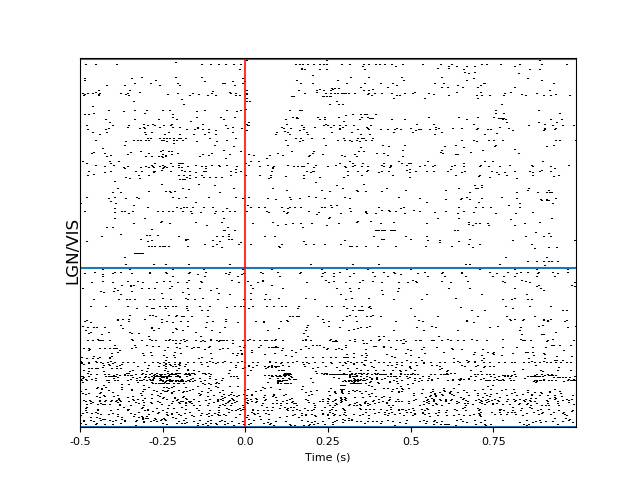

In [23]:
turn_on_xlabels = True
# ylabel_depth = True

fig, ax = plt.subplots() # figsize=(5,2.5)
ii = 0
for probei in probe_plot_order:
    unit_data = probe_unit_data[probei]
    
    for indi, spikes in enumerate(units_raster[probei]):
        ax.eventplot([spikes], lineoffsets=indi+ii, linelengths=0.95, color='black')
    ax.axhline(indi + ii + 1)
    ax.annotate(
        regions[probei],
#         '{:s}\nventral <-> dorsal'.format(regions[probei]),
        xy=(0, np.mean([ii, indi+ii])),
        xycoords='axes points',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical'
    )
    ii = indi + ii + 2

## Y labels
ax.axhline(-1)
ax.set_ylim([-2, ii+1])
plt.tick_params(axis='y', left=False, labelleft=False)

## X labels
ax.set_xlim([plot_time-plot_before, plot_time+plot_after])
if plot_event == 'stim':
    ax.axvline(plot_time, color='r', alpha=0.8)
if turn_on_xlabels:
    if plot_event == 'stim':
        ax.set_xticks(np.arange(plot_time-plot_before, plot_time+plot_after, 0.25))
        ax.set_xticklabels(np.arange(-plot_before, plot_after, 0.25), fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlabel('Time (s)', fontsize=8)
else:
    plt.tick_params(axis='x', labelbottom=False)

### EEG plot all channels

In [24]:
if plot_event == 'spont':
    plot_inds = np.squeeze(np.argwhere((eeg_ts > plot_time-plot_before) & (eeg_ts < plot_time+plot_after)))
    eeg_traces = eeg_data[plot_inds, :]
    eeg_xaxis = eeg_ts[plot_inds]
elif plot_event == 'stim':
    plot_inds = np.squeeze(np.argwhere((eeg_ts > plot_time-plot_before) & (eeg_ts < plot_time+plot_after)))
    eeg_traces = eeg_data[plot_inds, :]
    eeg_xaxis = eeg_ts[plot_inds] - plot_time

Filter the EEG with FIR filter, lowpass @ 200 Hz

In [25]:
## FIR filter ##
# design and check the lowpass filter kernel
filter_kernel_eeg = lowpass_filt_design(len(eeg_xaxis),
                                    exp.ephys_params['EEG']['sample_rate'],
                                    cutoff_freq=200,
                                    trans_width=0.2,
                                    order_multiple=11,
                                    plot_kern=False)
eeg_lowpass = signal.filtfilt(filter_kernel_eeg, 1, eeg_traces, axis=0)

Plot voltage traces from all chs

<IPython.core.display.Javascript object>


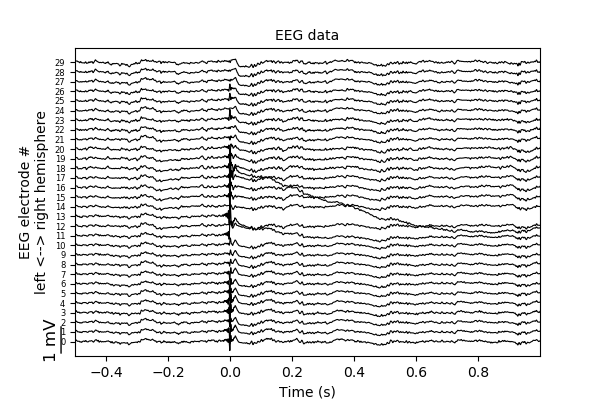

In [26]:
fig, ax = plt.subplots(figsize=(6,4))
sep = 300

for chind in eeg_chs:
    ax.plot(eeg_xaxis, eeg_lowpass[:,chind]+sep*chind, 'k', linewidth=0.8)

ax.annotate(
    '',
    xy=(-.03, 0), xycoords='axes fraction',
    xytext=(-.03, 1000/(sep*(chind+1.5) - (-sep*1.5))), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='-'),
    horizontalalignment='center', verticalalignment='center', rotation='vertical'
)
ax.annotate(
    '1 mV',
    xy=(-.05, 500/(sep*(chind+1.5) - (-sep*1.5))), xycoords='axes fraction',
    horizontalalignment='center', verticalalignment='center', rotation='vertical'
)

ax.set_xlim([eeg_xaxis[0], eeg_xaxis[-1]])
ax.set_ylim([-sep*1.5, sep*(chind+1.5)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG electrode #\nleft <--> right hemisphere')
ax.set_title('EEG data')
ax.get_yaxis().tick_left()
plt.yticks(range(0, sep*(chind+1), sep), eeg_chs, fontsize=6)

plt.show()

### Plot EEG and raster together

<IPython.core.display.Javascript object>


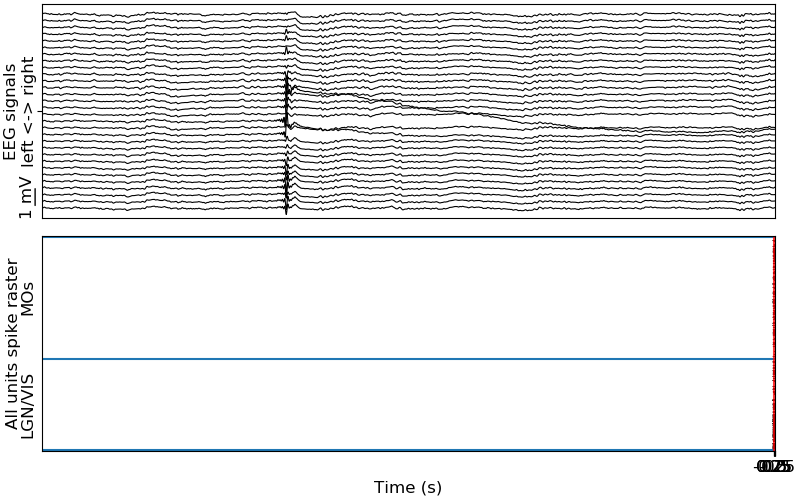

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(8,5), sharex=True, constrained_layout=True)

## Plot EEG on top ##
sep = 300
for chind in eeg_chs:
    axs[0].plot(eeg_xaxis, eeg_lowpass[:,chind]+sep*chind, 'k', linewidth=0.8)
axs[0].set_xlim([eeg_xaxis[0], eeg_xaxis[-1]])
axs[0].set_ylim([-sep*1.5, sep*(chind+1.5)])
axs[0].set_yticks([np.mean([-sep*1.5, sep*(chind+1.5)])])
axs[0].set_yticklabels([])
# axs[0].set_ylabel('EEG\nleft <-> right')
axs[0].annotate(
    'EEG signals\nleft <-> right',
    xy=(-0.03, 0.5),
    xycoords='axes fraction',
    horizontalalignment='center',
    verticalalignment='center',
    rotation='vertical',
    fontsize=12
)

# add scale bar #
axs[0].annotate(
    '',
    xy=(-.01, (sep*1.5)/(sep*(chind+1.5) - (-sep*1.5))), xycoords='axes fraction',
    xytext=(-.01, (sep*1.5+1000)/(sep*(chind+1.5) - (-sep*1.5))), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='-'),
    horizontalalignment='center', verticalalignment='center', rotation='vertical'
)
axs[0].annotate(
    '1 mV',
    xy=(-.02, (sep*1.5+500)/(sep*(chind+1.5) - (-sep*1.5))), xycoords='axes fraction',
    horizontalalignment='center', verticalalignment='center', rotation='vertical', fontsize=12
)

## Plot rasters ##
ii = 0
for probei in probe_plot_order:
    for indi, spikes in enumerate(units_raster[probei]):
        axs[1].eventplot([spikes], lineoffsets=indi+ii, linelengths=0.95, color='black')
    axs[1].axhline(indi + ii + 1)
    axs[1].annotate(
        regions[probei],
        xy=(-0.02, np.mean([ii, indi+ii])/total_units),
        xycoords='axes fraction',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        fontsize=12
    )
    ii = indi + ii + 2

## Y labels
axs[1].axhline(-1)
axs[1].set_ylim([-2, ii+1])
plt.tick_params(axis='y', left=False, labelleft=False)
axs[1].annotate(
    'All units spike raster',
    xy=(-0.04, 0.5),
    xycoords='axes fraction',
    horizontalalignment='center',
    verticalalignment='center',
    rotation='vertical',
    fontsize=12
)

## X labels
if plot_event == 'stim':
    axs[1].axvline(plot_time, color='r', alpha=0.8)
if turn_on_xlabels:
    if plot_event == 'stim':
        axs[1].set_xticks(np.arange(plot_time-plot_before, plot_time+plot_after, 0.25))
        axs[1].set_xticklabels(np.arange(-plot_before, plot_after, 0.25), fontsize=12)
    axs[1].tick_params(axis='x', labelsize=12)
    axs[1].set_xlabel('Time (s)', fontsize=12)
else:
    plt.tick_params(axis='x', labelbottom=False)
    
### SAVE ###
# fig.savefig(os.path.join(plotsavedir, 'urethane2_spont_EEG_raster_10s_5671.png'), transparent=True)

### Plot EEG and raster together with event times

## Average responses

Set plot parameters

In [20]:
plot_before = 0.2 # time before event, s
plot_after = 0.5 # time after event, s
plot_timebin = 0.001 # s
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = 60 # current amplitude = [20, 50, 70, 100]

In [21]:
EEG_traces = {}
unit_rates = {}
unit_zscores = {}

# get sweeps
sweeps = np.sort(stim_log[stim_log['stim_type']==stim_type].sweep.unique())[:3]
states = ['awake', 'anesthetized', 'recovery']

for statei, sweepi in zip(states, sweeps):
    start = time.time()
    events = get_stim_events(stim_log, stim_type, stim_amp, sweepi)
    
    ## EEG traces, filtered and averaged
    eeg_event_traces, eeg_event_ts = get_evoked_traces(
        eeg_data,
        eeg_ts,
        events,
        plot_before,
        plot_after,
        exp.ephys_params['EEG']['sample_rate']
    )
    # design eeg filter, Butterworth
    filtb, filta = signal.butter(
        3,
        100/(exp.ephys_params['EEG']['sample_rate']/2),
        btype='low'
    )
    filtered_eeg = signal.filtfilt(filtb, filta, eeg_event_traces, axis=0)
    EEG_traces[statei] = [eeg_event_ts, np.mean(filtered_eeg, axis=2)]
    
    ## Units
    # get evoked firing rates for all units
    unit_rates[statei] = {}
    unit_zscores[statei] = {}
    for probei, unit_data in probe_unit_data.items():
        event_trig_FR, spikerate_ts = get_evoked_firing_rates(
            unit_data['spike_times'],
            unit_data['spike_clusters'],
            unit_data['units'],
            events,
            plot_before,
            plot_after,
            plot_timebin
        )
        # get zscore
        event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)

        unit_rates[statei][probei] = [spikerate_ts, event_trig_FR]
        unit_zscores[statei][probei] = [spikerate_ts, event_trig_Z]
    
    end = time.time()
    print('{} time: {:.2f} s'.format(statei, (end - start)))

awake time: 24.54 s
anesthetized time: 22.96 s
recovery time: 24.14 s


### Plot all with z-score

<IPython.core.display.Javascript object>


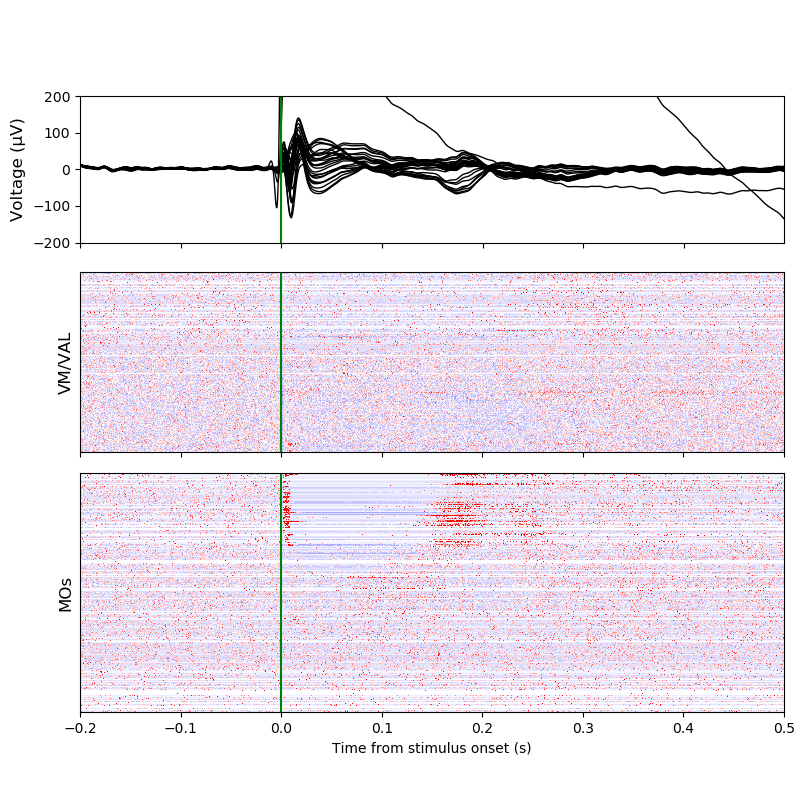

In [24]:
plot_state = 'awake' # 'awake' 'anesthetized'
y_limit = 200
set_Zrange = 5

fig = plt.figure(figsize=(8,8)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1,3], left=0.1, right=0.98, hspace=0.1)

## EEG butterfly plot ##
axeeg = fig.add_subplot(gs[0])
axeeg.plot(EEG_traces[plot_state][0], EEG_traces[plot_state][1], 'k', linewidth=1)
axeeg.set_xlim([EEG_traces[plot_state][0][0], EEG_traces[plot_state][0][-1]])
axeeg.set_ylim(-y_limit, y_limit)
axeeg.axvline(0, color='g')
axeeg.set_ylabel('Voltage (\u03BCV)', fontsize=12)
axeeg.set_xticklabels('')

## Unit z-score, all probes ##
gs_units = gs[1].subgridspec(ncols=1, nrows=len(unit_zscores[plot_state].keys()), height_ratios=[len(probe_unit_data[x]['units']) for x in probe_unit_data.keys()], hspace=0.1)
for ii, (probei, zscoredata) in enumerate(unit_zscores[plot_state].items()):
    axzsc = fig.add_subplot(gs_units[ii])
    units_plot = axzsc.imshow(
        zscoredata[1],
        cmap='bwr',
        interpolation='none',
        aspect='auto',
        origin='lower',
        vmin=-set_Zrange,
        vmax=set_Zrange,
        extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
    )
    axzsc.axvline(0, color='g')
    if ii == 0:
        axzsc.set_xticklabels('')
    else:
        axzsc.set_xlabel('Time from stimulus onset (s)')
    plt.tick_params(axis='y', left=False, labelleft=False)
    axzsc.annotate(
        regions[probei],
        xy=(-0.02, 0.5),
        xycoords='axes fraction',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        fontsize=12
    )

# cbar = plt.colorbar(units_plot, ax=axzsc)
# cbar.set_label('Firing rate (Z-score)', fontsize=12)
# cbar.ax.tick_params(labelsize=12)
    
### SAVE ###
# fig.savefig(os.path.join(plotsavedir, 'earlyUR_estim_EEG_raster_EP.png'), transparent=True)

In [ ]:
# combo_fig_name = 'recovery_evoked_EEGmask_zscore_LFP.png'
choose_state = 'awake'
set_vrange = 1 # mV
set_Zrange = 5 # std
ylabel_depth = True

fig = plt.figure(figsize=(7.25, 7.5), constrained_layout=True)

gs = GridSpec(3, 1, figure=fig)
eegax = fig.add_subplot(gs[0, :])
unitsax = fig.add_subplot(gs[1, :])
lfpax = fig.add_subplot(gs[2, :])

### EEG plot ###
mask_bad_chs = True

plot_traces = EEG_traces[choose_state][1].T/1000
if mask_bad_chs:
    mask_traces = np.zeros((len(bad_chs), np.shape(plot_traces)[1]))
    plot_traces[bad_chs,:] = mask_traces

traces_plot = eegax.imshow(
    plot_traces,
    cmap='bwr',
    aspect='auto',
    vmin=-set_vrange,
    vmax=set_vrange,
    extent=[EEG_traces[choose_state][0][0], EEG_traces[choose_state][0][-1], len(eeg_chs), 0],
)
## X labels
eegax.tick_params(axis='x', labelbottom=False)

## Y labels
eegax.axhline(len(eeg_chs)/2, color='k', linewidth=0.8)
eegax.set_yticks([len(eeg_chs)/2])
eegax.set_yticklabels([])
eegax.set_ylabel('EEG\nright <---> left')

## Color bar
cbar = plt.colorbar(traces_plot, ax=eegax)
cbar.set_label('Voltage (mV)', fontsize=9)
cbar.ax.tick_params(labelsize=8)

### Unit firing rate plot ###
units_plot = unitsax.imshow(
    unit_zscores[choose_state][1],
    cmap='bwr',
    interpolation='none',
    aspect='auto',
    origin='lower',
    vmin=-set_Zrange,
    vmax=set_Zrange,
    extent=[unit_zscores[choose_state][0][0], unit_zscores[choose_state][0][-1], 0, len(sorted_units)],
)

## X labels
unitsax.tick_params(axis='x', labelbottom=False)
# unitsax.axvline(0, color='r', alpha=0.8)

## Y labels
if ylabel_depth:
    unitsax.set_yticks(np.arange(0, len(sorted_units), 50))
#     ax.set_yticklabels(npx_ch_depths[np.arange(0, len(sorted_units), 50)]/1000)
    unitsax.set_yticklabels(npx_ch_depths[sorted_peak_chs[np.arange(0, len(sorted_units), 50)]]/1000, fontsize=9)
    unitsax.set_ylabel('Units\n(mm from brain surface)')
else:
    unitsax.set_ylabel('Units\ndeep <---> superficial')
    
## Color bar
cbar = plt.colorbar(units_plot, ax=unitsax)
cbar.set_label('Z-score', fontsize=9)
cbar.ax.tick_params(labelsize=8)

### LFP plot ###
lfp_plot = lfpax.imshow(
    LFP_traces[choose_state][1].T/1000,
    cmap='bwr',
    aspect='auto',
    origin='lower',
    vmin=-set_vrange,
    vmax=set_vrange,
    extent=[LFP_traces[choose_state][0][0]/1000, LFP_traces[choose_state][0][-1]/1000, 0, len(npx_chs)],
)
## X labels
lfpax.tick_params(axis='x', labelsize=9)
lfpax.set_xlabel('Time (s)', fontsize=9)
    
## Y labels
if ylabel_depth:
    lfpax.set_yticks(np.arange(0, LFP_traces[choose_state][1].shape[1], 50))
    lfpax.set_yticklabels(npx_ch_depths[np.arange(0, LFP_traces[choose_state][1].shape[1], 50)]/1000, fontsize=9)
    lfpax.set_ylabel('Npx LFP\n(mm from brain surface)')
else:
    lfpax.set_ylabel('Npx electrode #\ndeep <---> superficial')

## Color bar
cbar = plt.colorbar(lfp_plot)
cbar.set_label('Voltage (mV)', fontsize=9)
cbar.ax.tick_params(labelsize=8)

### SAVE ###
# fig.savefig(os.path.join(plotsavedir, combo_fig_name), transparent=True)

### LFP plot all channels

Do I need to filter the LFP?? Maybe a bandpass 0.5 to 50 Hz?

#### High, then low pass filter

Plot all chs as heat map

## Plot them all together